In [118]:
import math
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import v2
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import models
import utils

In [119]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)
test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)
device=utils.get_device()

In [120]:
composite_data = torch.load('data/composite_test.pt')
composite_dataset = TensorDataset(composite_data['images'], composite_data['output_seqs'])
composite_dataloader = DataLoader(composite_dataset, batch_size=64, shuffle=False)

In [121]:
images, labels = next(iter(composite_dataloader))
labels.shape

torch.Size([64, 5])

In [122]:
images.shape


torch.Size([64, 1, 56, 56])

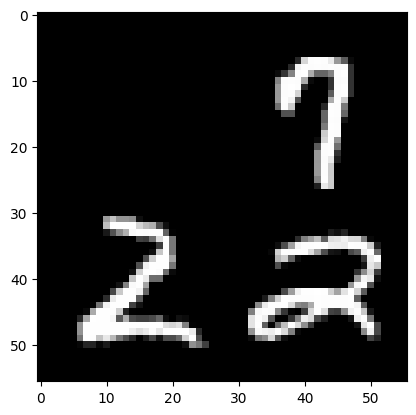

In [123]:
plt.imshow(images[8].reshape(56,56), cmap="gray")
plt.show()

In [124]:
images, labels = next(iter(test_dataloader))
labels

tensor([7, 2, 1,  ..., 7, 5, 4])

In [125]:
image = images[0]
c, h, w = image.shape
unfolder = nn.Unfold(kernel_size=14, stride=14)
patches = unfolder(images)
patches.shape

torch.Size([1024, 196, 4])

In [126]:
rotated = patches.permute(0, 2, 1)
rotated.shape

torch.Size([1024, 4, 196])

In [127]:
linear = nn.Linear(196, 64, bias=False)
result = linear(rotated)
result.shape

torch.Size([1024, 4, 64])

In [128]:
rotated[0].shape

torch.Size([4, 196])

In [129]:
loss_fn = nn.CrossEntropyLoss()

In [130]:
patchify = models.Patchify(7, 64)
encoders = nn.ModuleList([models.Encoder(model_dim=64, ffn_dim=64, num_heads=8) for _ in range(6)])
linear = nn.Linear(64, 10)
patched = patchify(images)
for encoder in encoders:
    patched = encoder(patched)
result = linear(patched)
result.shape

torch.Size([1024, 16, 10])

In [131]:
meaned = result.mean(dim=1)
meaned.shape

torch.Size([1024, 10])

In [132]:
labels.shape

torch.Size([1024])

In [133]:
loss_fn = nn.CrossEntropyLoss()
loss= loss_fn(meaned, labels)
loss.backward()

In [134]:
# pe work
pe = torch.zeros(128, 64)
position = torch.arange(0, 128, dtype=torch.float).unsqueeze(1)
pe.shape


torch.Size([128, 64])

In [135]:
position.shape

torch.Size([128, 1])

In [136]:
# div_term = torch.exp()
evens = torch.arange(0, 64, 2)
magic = math.log(10_000.0) / 64
div_terms = evens * - magic
div_terms = torch.exp(div_terms)
# div_terms.shape == 32
div_terms

tensor([1.0000e+00, 7.4989e-01, 5.6234e-01, 4.2170e-01, 3.1623e-01, 2.3714e-01,
        1.7783e-01, 1.3335e-01, 1.0000e-01, 7.4989e-02, 5.6234e-02, 4.2170e-02,
        3.1623e-02, 2.3714e-02, 1.7783e-02, 1.3335e-02, 1.0000e-02, 7.4989e-03,
        5.6234e-03, 4.2170e-03, 3.1623e-03, 2.3714e-03, 1.7783e-03, 1.3335e-03,
        1.0000e-03, 7.4989e-04, 5.6234e-04, 4.2170e-04, 3.1623e-04, 2.3714e-04,
        1.7783e-04, 1.3335e-04])

In [137]:
sines = torch.sin(position * div_terms)
cosines = torch.cos(position * div_terms)
sines.shape

torch.Size([128, 32])

In [138]:
tensors = torch.load("data/composite_train.pt")
tensors

{'images': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
   

In [139]:
# insert values to zero'ed positional embedding tensor with shape 128x64
# sines and cosines have shape 128x32
pe[:, 0::2] = sines
pe[:, 1::2] = cosines
pe

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
          1.3335e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
          2.6670e-04,  1.0000e+00],
        ...,
        [-6.1604e-01,  7.8771e-01, -4.8905e-01,  ...,  9.9975e-01,
          1.6668e-02,  9.9986e-01],
        [ 3.2999e-01,  9.4398e-01,  2.3663e-01,  ...,  9.9975e-01,
          1.6802e-02,  9.9986e-01],
        [ 9.7263e-01,  2.3236e-01,  8.3536e-01,  ...,  9.9975e-01,
          1.6935e-02,  9.9986e-01]])

In [140]:
pe = pe.unsqueeze(0)
pe.shape

torch.Size([1, 128, 64])

In [141]:
pe

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
           1.3335e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
           2.6670e-04,  1.0000e+00],
         ...,
         [-6.1604e-01,  7.8771e-01, -4.8905e-01,  ...,  9.9975e-01,
           1.6668e-02,  9.9986e-01],
         [ 3.2999e-01,  9.4398e-01,  2.3663e-01,  ...,  9.9975e-01,
           1.6802e-02,  9.9986e-01],
         [ 9.7263e-01,  2.3236e-01,  8.3536e-01,  ...,  9.9975e-01,
           1.6935e-02,  9.9986e-01]]])

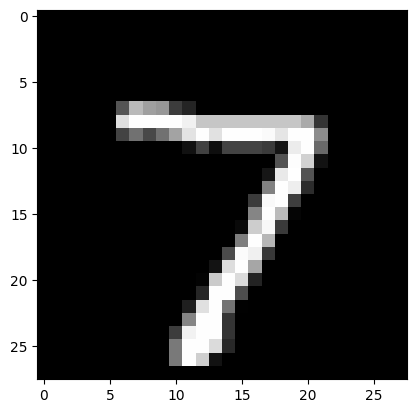

In [142]:
plt.imshow(image.reshape(28,28), cmap="gray")
plt.show()

In [143]:
images.shape

torch.Size([1024, 1, 28, 28])

In [144]:
device = utils.get_device()
checkpoint = torch.load("data/simple.pth", map_location=device)
model = models.SimpleTransformer(patch_size=14, model_dim=384, ffn_dim=64, num_encoders=3, num_heads=8, use_pe=True).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
pe = model.pe.pe
pe

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.1525e-01,  ...,  1.0000e+00,
           1.0491e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.4424e-01,  ...,  1.0000e+00,
           2.0983e-04,  1.0000e+00],
         ...,
         [-9.6612e-01, -2.5810e-01,  9.9973e-01,  ...,  9.9998e-01,
           6.3997e-03,  9.9998e-01],
         [-7.3918e-01,  6.7351e-01,  5.5986e-01,  ...,  9.9998e-01,
           6.5046e-03,  9.9998e-01],
         [ 1.6736e-01,  9.8590e-01, -3.5128e-01,  ...,  9.9998e-01,
           6.6095e-03,  9.9998e-01]]], device='mps:0')

In [145]:
pe.std().item()

0.5954260230064392

In [146]:
pe.mean().item()

0.38142141699790955

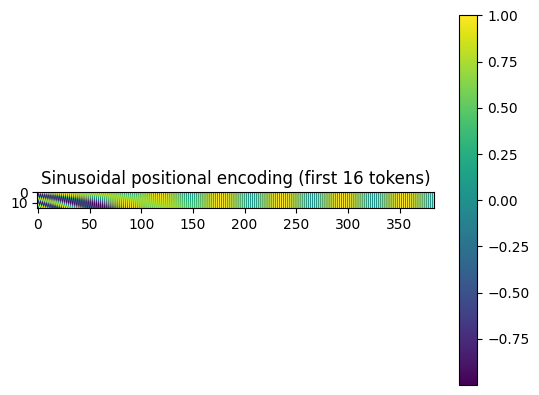

In [147]:
plt.imshow(pe[0, :16].cpu())   # first batch, 16 tokens
plt.colorbar()
plt.title("Sinusoidal positional encoding (first 16 tokens)")
plt.show()

In [148]:
blankpe = models.PositionalEncoding(64).pe[0]      # [max_len, 64]

# Column 0 should be sin wave, column 1 a cos wave
assert torch.allclose(blankpe[:4,0], torch.tensor([0., 0.8415, 0.9093, 0.1411]), atol=1e-3)

# Column 63 (highest freq) should be almost exactly 0/1 for pos<16
assert (blankpe[:16,63] - 1).abs().max() < 1e-3

In [149]:
blankpe.mean().item()

0.37666529417037964

In [150]:
blankpe.std().item()

0.5985070466995239

In [151]:
encoder = model.encoders[0]

In [152]:
images = images.to(device)

In [153]:
images.device

device(type='mps', index=0)

In [155]:
images.shape

torch.Size([1024, 1, 28, 28])

In [157]:
model

Classifier(
  (patchify): Patchify(
    (unfold): Unfold(kernel_size=14, dilation=1, padding=0, stride=14)
    (linear): Linear(in_features=196, out_features=384, bias=False)
  )
  (pe): PositionalEncoding()
  (encoders): ModuleList(
    (0-2): 3 x Encoder(
      (mha): MultiHeadAttention(
        (wqkv): Linear(in_features=384, out_features=1152, bias=False)
        (endmulti): Linear(in_features=384, out_features=384, bias=False)
      )
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (sequence): Sequential(
          (0): Linear(in_features=384, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=384, bias=True)
        )
      )
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
  )
  (linear): Sequential(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=384, out_features=384, bias=True)
    (2): GELU(approximate='

In [159]:
patchify=model.patchify

In [163]:
patches = patchify.unfold(images)

In [164]:
patches.shape

torch.Size([1024, 196, 4])

In [167]:
rotated = patches.permute(0,2,1)
rotated.shape

torch.Size([1024, 4, 196])

In [169]:
patched = patchify.linear(rotated)
patched.shape

torch.Size([1024, 4, 384])

In [154]:
B = images.size(0)

D = patched.size(2)
patched = model.pe(patched)
cls_expanded = model.cls_token.expand(B, 1, D)
withcls = torch.cat([cls_expanded, patched], dim=1)

RuntimeError: number of dims don't match in permute

In [115]:
endhead = nn.Linear(32, 64, bias=False).to(device)
norm1 = nn.LayerNorm(64).to(device)
norm2 = nn.LayerNorm(64).to(device)


In [116]:
q = encoder.wq(x)
k = encoder.wk(x)
v = encoder.wv(x)
kt = k.permute(0, 2, 1)

# do attention(Q, K, V) = softmax(Q·K^T / sqrt(dims))·V to get hidden state (where · is dot product)
attn_dot_product = torch.matmul(q, kt)
attn_scaled = attn_dot_product / math.sqrt(models.K_DIM)
attn_probs = torch.softmax(attn_scaled, dim=1)
hidden = torch.matmul(attn_probs, v)
sublayer1 = endhead(hidden)

AttributeError: 'Encoder' object has no attribute 'wq'

In [521]:
print(x.shape)
print(q.shape)
print(k.shape)
print(v.shape)
print(kt.shape)
print(attn_dot_product.shape)
print(attn_scaled.shape)
print(attn_probs.shape)
print(hidden.shape)
print(sublayer1.shape)

torch.Size([64, 16, 64])
torch.Size([64, 16, 24])
torch.Size([64, 16, 24])
torch.Size([64, 16, 32])
torch.Size([64, 24, 16])
torch.Size([64, 16, 16])
torch.Size([64, 16, 16])
torch.Size([64, 16, 16])
torch.Size([64, 16, 32])
torch.Size([64, 16, 64])


In [522]:
addnormed = norm1(x + sublayer1)
addnormed.shape

torch.Size([64, 16, 64])

In [523]:
myffn=     nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        ).to(device)

In [524]:

# pass attention output through feed-forward sub-layer (basic MLP)
ffned = myffn(addnormed)
added = addnormed + ffned
final = norm2(added)

In [525]:
final.shape

torch.Size([64, 16, 64])

In [526]:
encoded = encoder(x)

In [527]:
encoded.shape

torch.Size([64, 16, 64])